In [1]:
import seaborn as sns
from matplotlib.font_manager import fontManager, FontProperties
from matplotlib import pyplot as plt
from paths import TEST_OUTPUT_DIR
import pandas as pd

In [2]:
path = "NotoSansTC-Medium.ttf"
fontManager.addfont(path)

prop = FontProperties(fname=path)
sns.set(font=prop.get_name())

In [3]:
model_tests = {
    "no_controlnet": "僅基底",
    "0_hackersong": "舊版",
    "1": "第一代",
    "1_train_base": "第一代\n解鎖基底",
    "2": "第二代",
    "2_train_base": "第二代\n解鎖基底",
    "3_beat_mark": "第三代\n(人聲拍點)",
    "3_beat_mark-[from_accompaniment]": "第三代\n(伴奏拍點)",
    "3_beat_mark_train_base": "第三代\n解鎖基底\n(人聲拍點)",
    "3_beat_mark_train_base-[from_accompaniment]": "第三代\n解鎖基底\n(伴奏拍點)",
    "3_beat_mark_width_5": "第四代？"
}

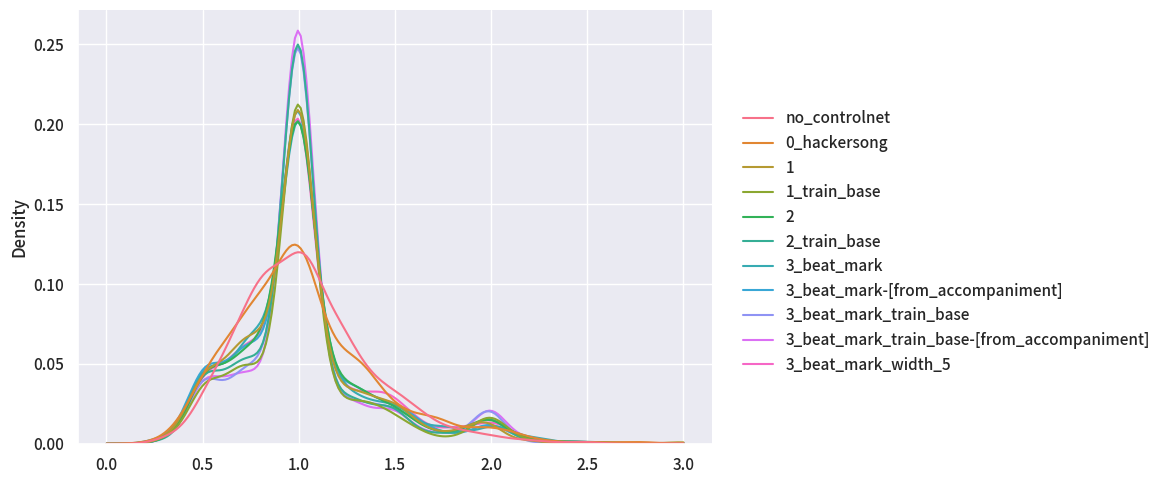

In [4]:
data = pd.DataFrame()

for model_test in model_tests:
    df = pd.read_csv(TEST_OUTPUT_DIR / f"{model_test}_bs.csv")
    data[model_test] = df["ground_truth_bpm"] / df["output_bpm"]

sns.displot(data, kind="kde", aspect=1.5, clip=(3, 0))


<Axes: >

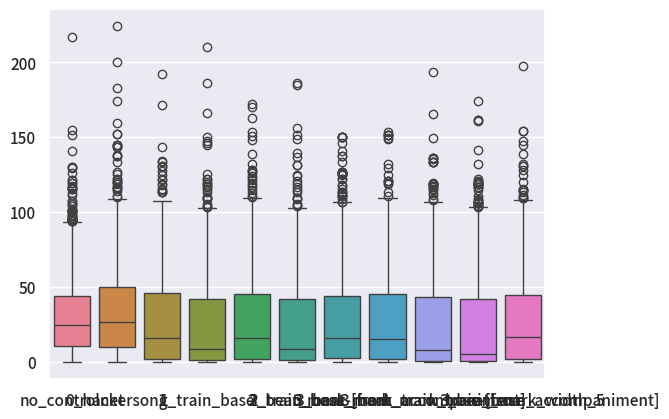

In [5]:
for model_test in model_tests:
    df = pd.read_csv(TEST_OUTPUT_DIR / f"{model_test}_bs.csv")
    data[model_test] = abs(df["ground_truth_bpm"] - df["output_bpm"])

sns.boxplot(data)

<Axes: xlabel='模型名稱', ylabel='較小BPM與較大BPM比值'>

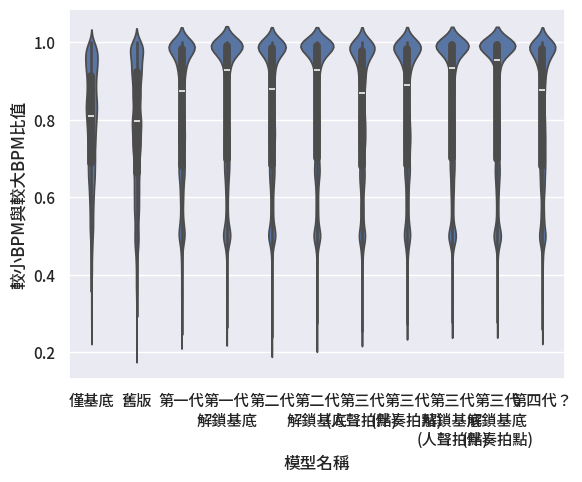

In [6]:
import numpy as np

perfect_ratios = np.array([1, 1 / 2])
data = {
    "模型名稱": [],
    "較小BPM與較大BPM比值": []
}

for model_test in model_tests.keys():
    df = pd.read_csv(TEST_OUTPUT_DIR / f"{model_test}_bs.csv")
    min_ratio_diffs = []

    for i, row in df.iterrows():
        ratio = min((row["ground_truth_bpm"], row["output_bpm"])) / max((row["ground_truth_bpm"], row["output_bpm"]))
        # min_ratio_diff = np.min(np.abs(perfect_ratios - ratio))
        # min_ratio_diffs.append(min_ratio_diff)

        data["模型名稱"].append(model_tests[model_test])
        data["較小BPM與較大BPM比值"].append(ratio)

sns.violinplot(data, x="模型名稱", y="較小BPM與較大BPM比值", bw_adjust=.5)

In [7]:
import numpy as np
import seaborn.objects as so

data = {
    "模型名稱": [],
    "範圍": [],
    "所佔比例 (%)": [],
}

for model_test in model_tests.keys():
    df = pd.read_csv(TEST_OUTPUT_DIR / f"{model_test}_bs.csv")

    bin_counter = {
        "0.99 ~ 1": 0,
        "0.98 ~ 0.99": 0,
        "0.98 ~ 0.95": 0,
        "0.49 ~ 0.51": 0,
        "其他": 0,
    }

    for i, row in df.iterrows():
        ratio = min((row["ground_truth_bpm"], row["output_bpm"])) / max((row["ground_truth_bpm"], row["output_bpm"]))

        if ratio > 0.99:
            bin_counter["0.99 ~ 1"] += 1
        elif ratio > 0.98:
            bin_counter["0.98 ~ 0.99"] += 1
        elif ratio > 0.95:
            bin_counter["0.98 ~ 0.95"] += 1
        elif 0.49 < ratio < 0.51:
            bin_counter["0.49 ~ 0.51"] += 1
        else:
            bin_counter["其他"] += 1

    bin_counter["無法辨識節拍"] = 2220 - sum(bin_counter.values())

    for key in ["0.99 ~ 1", "0.98 ~ 0.99", "0.98 ~ 0.95", "0.49 ~ 0.51", "其他", "無法辨識節拍"]:
        data["模型名稱"].append(model_tests[model_test])
        data["範圍"].append(key)
        data["所佔比例 (%)"].append(bin_counter[key] / 2220 * 100)

    模型名稱           範圍   所佔比例 (%)
0    僅基底     0.99 ~ 1   2.432432
1    僅基底  0.98 ~ 0.99   2.432432
2    僅基底  0.98 ~ 0.95   8.423423
3    僅基底  0.49 ~ 0.51   0.990991
4    僅基底           其他  75.225225
..   ...          ...        ...
61  第四代？  0.98 ~ 0.99   9.279279
62  第四代？  0.98 ~ 0.95  11.801802
63  第四代？  0.49 ~ 0.51   5.090090
64  第四代？           其他  57.027027
65  第四代？       無法辨識節拍   0.675676

[66 rows x 3 columns]


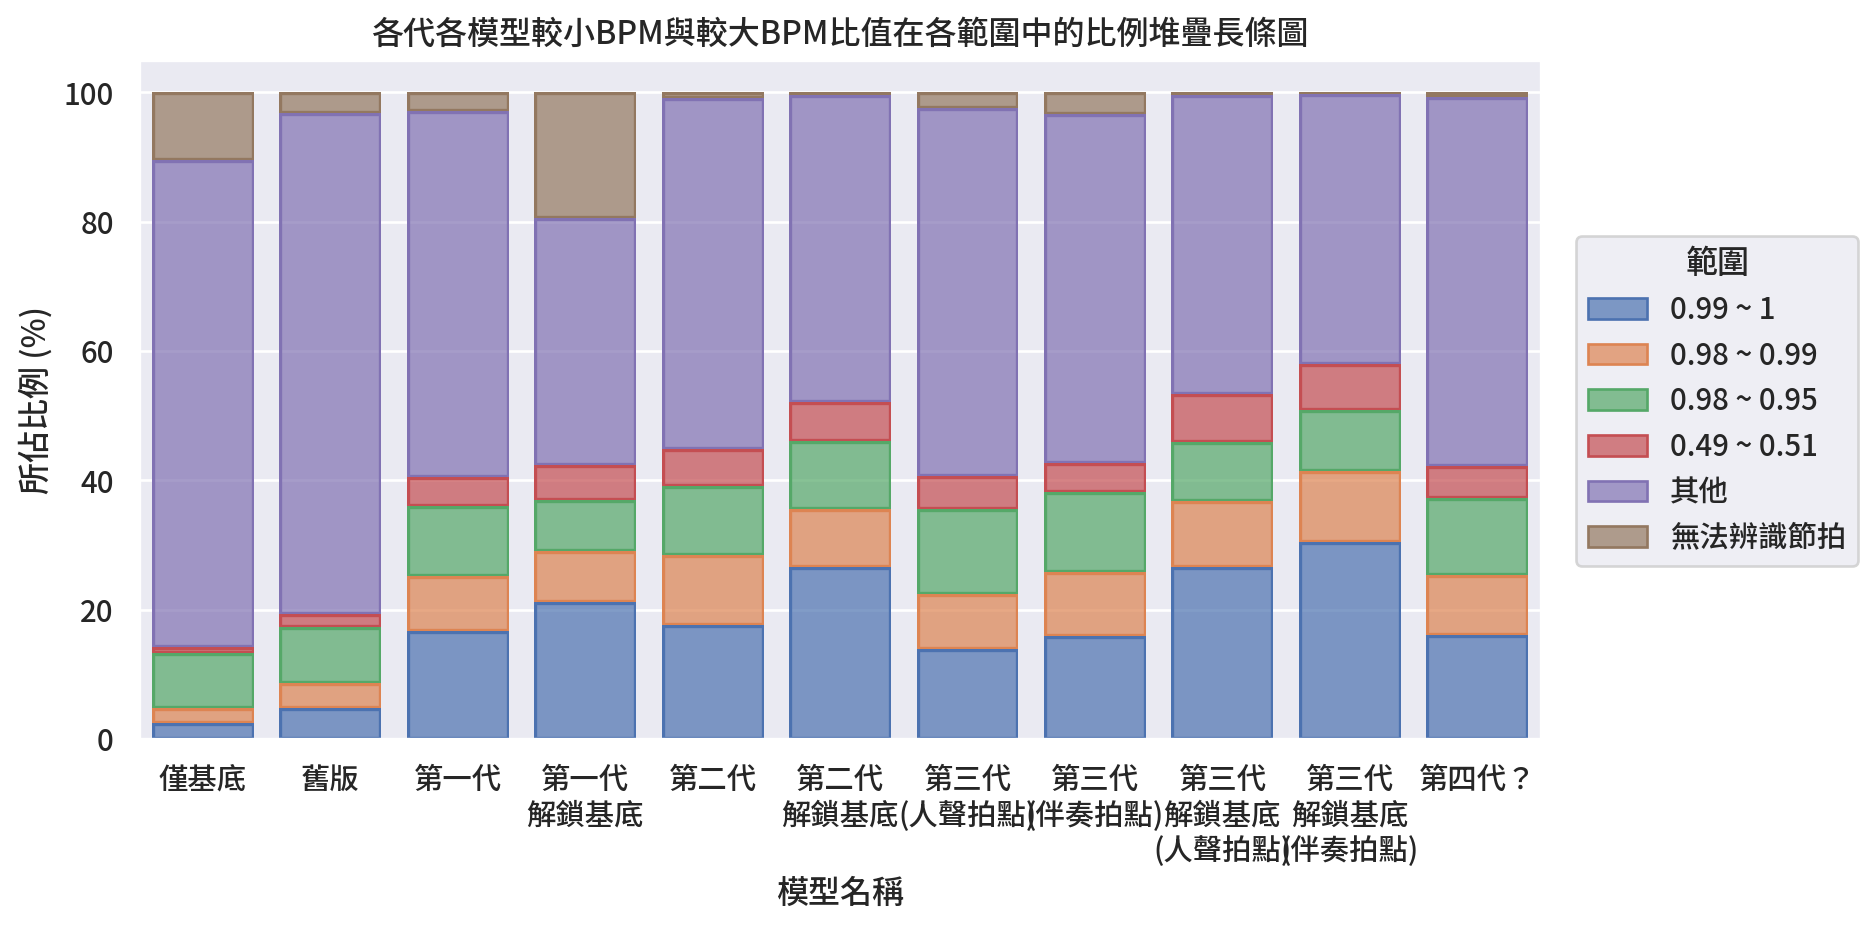

In [8]:
df = pd.DataFrame(data)

print(df)
plt = (
    so.Plot(data, x="模型名稱", y="所佔比例 (%)", color="範圍")
    .add(so.Bar(), so.Stack())
    .label(title="各代各模型較小BPM與較大BPM比值在各範圍中的比例堆疊長條圖", x="模型名稱", y="所佔比例 (%)")
    .layout(size=(8.3, 5))
)

plt.theme({"font.family": prop.get_name()})